In [1]:
%pip install -q pytorch-lightning
%pip install -q tabulate

Note: you may need to restart the kernel to use updated packages.


In [13]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
import cv2
import albumentations as A
import random

import os
from pathlib import Path
from tqdm import tqdm
from collections import OrderedDict

import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from tabulate import tabulate

# Select GPU device for the training if available
if not torch.cuda.is_available():
    device=torch.device("cpu")
    print("Current device:", device)
else:
    device=torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Current device: cpu


In [8]:
# Do arquivo utils/config.py:
LESIONS_IDRID = {0: 'MA', 1: 'HE', 2:'EX', 3:'SE', 4:'OD'}

In [155]:
class IDRIDDataset(Dataset):
    def __init__(self, images_dir: Path, masks_dir: Path, class_id=0, transform=None):
        super().__init__()
        """
        Args:
            image_dir: Path para o diretório de fundoscopias
            mask_dir: Path para o diretório de diretórios de mascaras
            class_id: {0: 'MA', 1: 'HE', 2:'EX', 3:'SE', 4:'OD'}
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.class_id = class_id
        self.transform = transform
        self.images_paths = []
        self.masks_paths = []
        self.images = []
        self.masks = []

        # variavel que armazena qual diretório de lesões será usado
        mask_path4 = sorted(masks_dir.iterdir())[class_id]

        for img_path in sorted(images_dir.glob('*.jpg')):
          # Essa condicional atua no fato de que não há a mesma quantidade de mascara por lesão
          if Path(mask_path4 / (img_path.stem+'_'+LESIONS_IDRID[class_id]+'.tif')).exists():
            mask_path = mask_path4 / (img_path.stem+'_'+LESIONS_IDRID[class_id]+'.tif')
            self.images_paths.append(img_path)
            self.masks_paths.append(mask_path)
            # print(img_path,"\t\t", mask_path)
            self.images.append(self.img_loader(img_path,dataset='IDRID'))
            self.masks.append(self.img_loader(mask_path,is_mask=True, dataset='IDRID'))
            
    @staticmethod
    def img_loader(image_path: Path,is_mask=False, dataset='IDRID'):
        with open(image_path, 'rb') as f:
            if dataset=="DIARETDB":
                if not is_mask:
                    img = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))

                    return img
                else:
                    mask = cv2.imread(str(image_path), 0)
                    mask = cv2.resize(mask, (224, 224))
                    mask = cv2.threshold(mask, 240, 255, cv2.THRESH_BINARY)[1]
                    
                    return mask
                
            elif dataset=="IDRID":
                if not is_mask:
                    img = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))

                    # #Remorção do Disco:
                    # r,g,b = cv2.split(img)
                    # optic_disk_mask = cv2.imread(image_path.with_stem(image_path.stem + '_OD').with_suffix('.tif'))[:,:,2]
                    # optic_disk_mask = cv2.resize(optic_disk_mask, (224, 224))
                    # optic_disk_mask = cv2.threshold(optic_disk_mask, 240, 255, cv2.THRESH_BINARY)[1]
                    # sub_r, sub_g, sub_b = list(map(lambda img: cv2.subtract(img, optic_disk_mask), [r,g,b]))
                    # merged = cv2.merge(sub_r, sub_g, sub_b)
                    
                    # return merged
                    return img
                else:
                    mask = cv2.imread(str(image_path))[:, :, 2]
                    mask = cv2.resize(mask, (224, 224))
                    mask = cv2.threshold(mask, 240, 255, cv2.THRESH_BINARY)[1]

                    return mask

    def __len__(self):
        assert len(self.images_paths) == len(self.masks_paths)
        return len(self.images_paths) 
    
    def __getitem__(self, idx):
        """Retorna a imagem e sua mascara vazia em forma de tensor, aplica transformações se houver"""
        image = self.images[idx]
        true_mask = self.masks[idx]

        if self.transform: 
            aug = self.transform(image=image, mask=true_mask)
            image = aug['image']
            true_mask = aug['mask']
        
        # Talvez tenha np.expand_dims relação com as falhas de dimensão quando tentei pytorchlighting
        norm = A.Normalize()(image=image, mask=np.expand_dims(true_mask,0)) 

        # TypeCasting
        image, true_mask = torch.from_numpy(image).float().contiguous(), torch.from_numpy(true_mask).long().contiguous()

        return norm['image'].transpose(2, 0, 1), norm['mask']  
        

In [132]:
#--->> Path para treino
TRAINSET_IMGS = Path("datasets/A. Segmentation/1. Original Images/a. Training Set")
TRAINSET_DIR_MASKS = Path("datasets/A. Segmentation/2. All Segmentation Groundtruths/a. Training Set")
#--->> Path para teste
TESTSET_IMGS = Path("datasets/A. Segmentation/1. Original Images/b. Testing Set")
TESTSET_DIR_MASKS = Path("datasets/A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set")


In [156]:
# "Albumentations garante que a imagem de entrada e a máscara de saída recebam o mesmo conjunto de aumentos com os mesmos parâmetros."
t = A.Compose([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.GaussNoise(),
               A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5), p=0.4)])

# datasets
train_dataset = IDRIDDataset(TRAINSET_IMGS, TRAINSET_DIR_MASKS, 2, t)

n_val = int(len(train_dataset) * 0.1)
n_train = len(train_dataset) - n_val
train_dataset, valid_dataset = random_split(train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

test_dataset = IDRIDDataset(TESTSET_IMGS, TESTSET_DIR_MASKS, 2)

# dataloader
batch_size = 4

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dl = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


# Visualization

DATALOADER DE TREINO ****************************************************************************************************
Como as imagens estão normalizadas: coloca-se entre [0,1] para visualização.


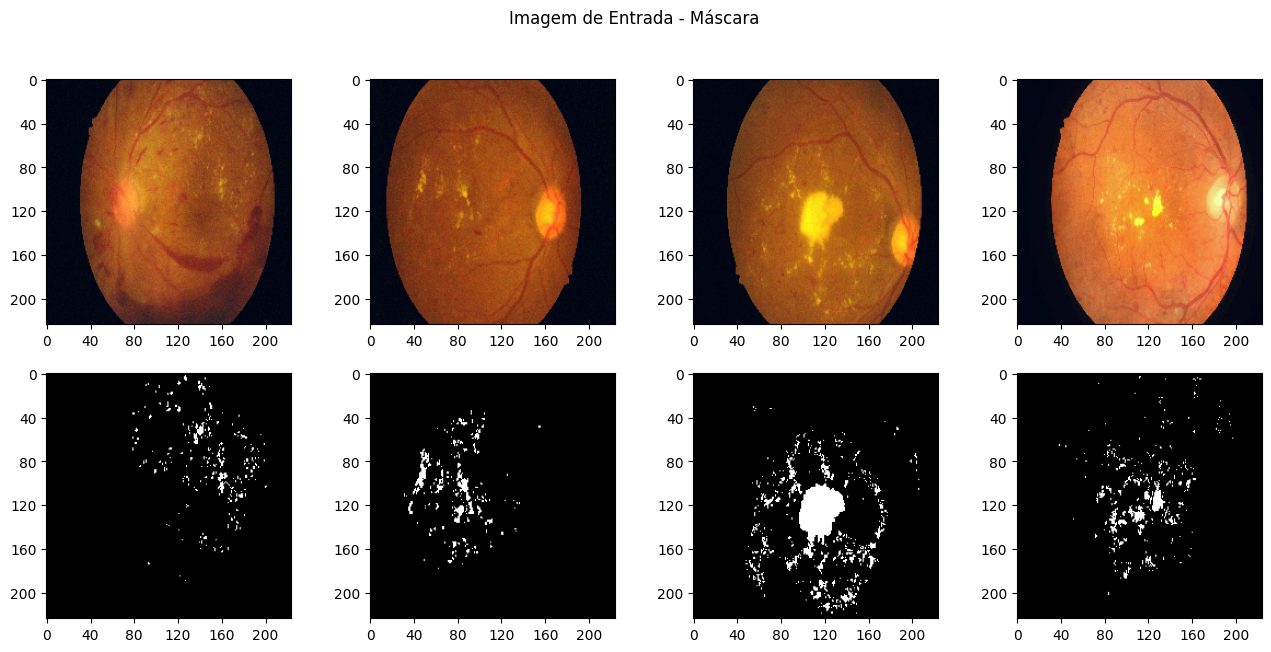

DATALOADER DE VALIDAÇÃO ****************************************************************************************************
Como as imagens estão normalizadas: coloca-se entre [0,1] para visualização.


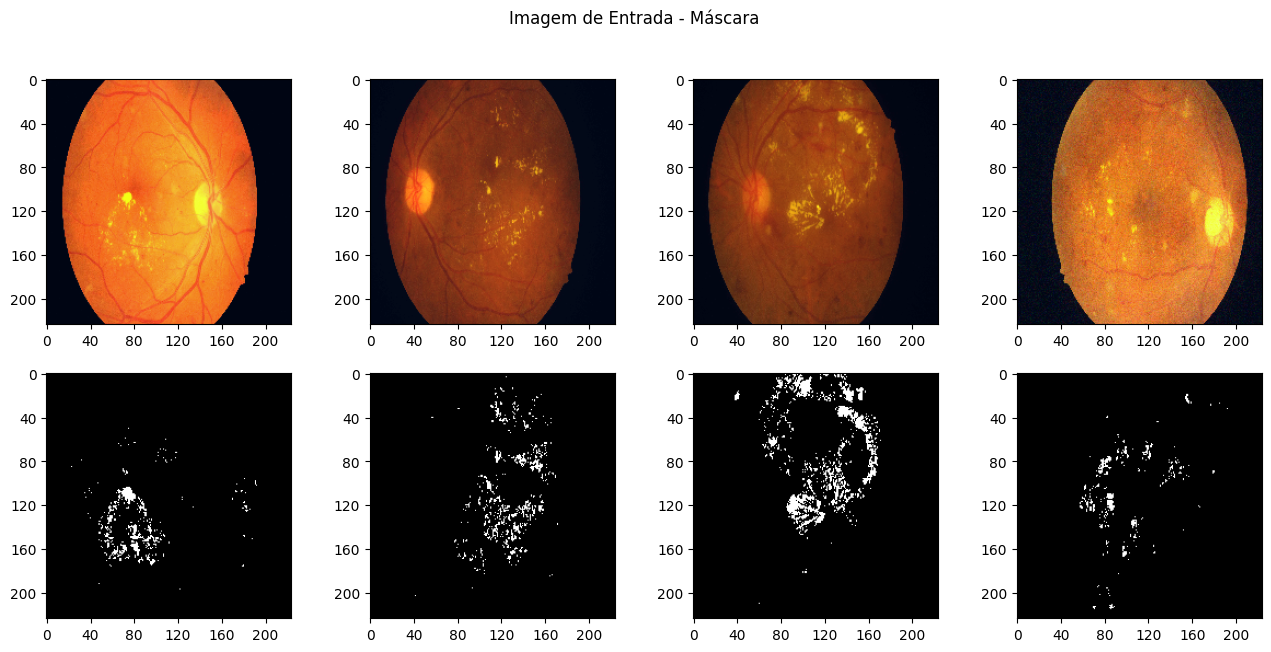

DATALOADER DE TESTE ****************************************************************************************************
Como as imagens estão normalizadas: coloca-se entre [0,1] para visualização.


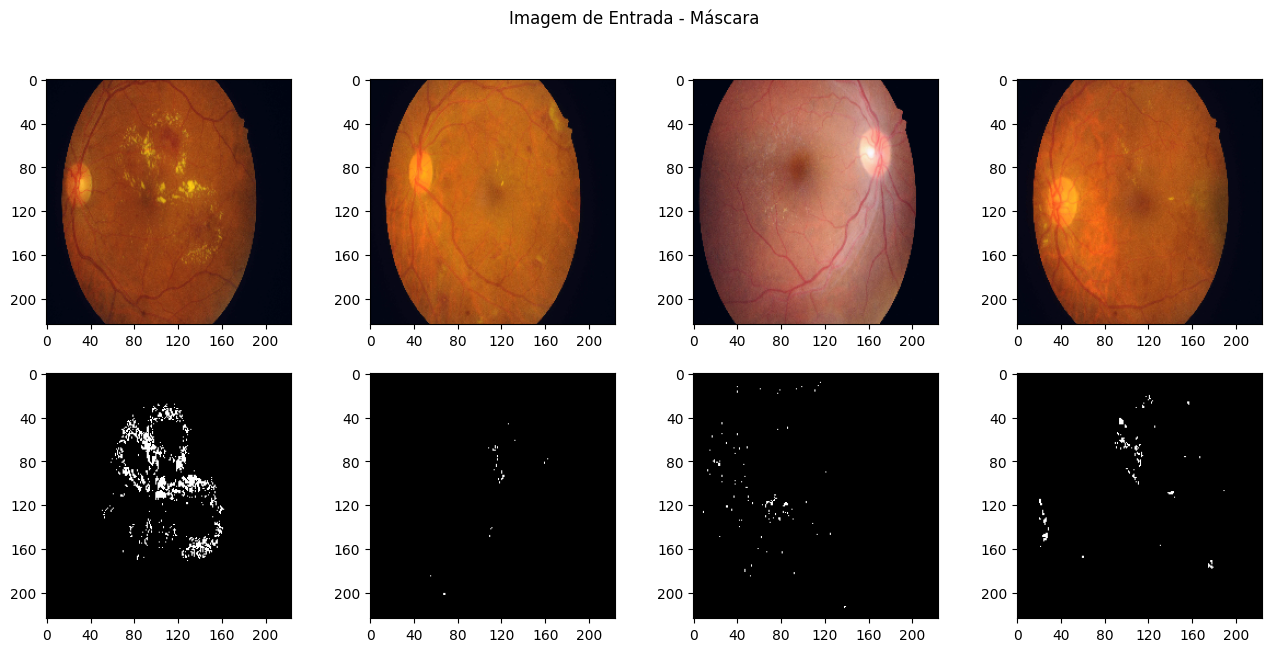

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_img_and_mask(batch_imgs: torch.tensor, batch_masks: torch.tensor):
    '''Recebe um lote de imagens e um lote de mascaras e plota as imagens e as mascaras respectivas'''
    print("Como as imagens estão normalizadas: coloca-se entre [0,1] para visualização.")
    fig, ax = plt.subplots(2, batch_imgs.size()[0], figsize=(4 * batch_imgs.size()[0],7))
    for (i, img), mask in zip(enumerate(batch_imgs), batch_masks):
        # Obs: o tipo teve que ser mudado para torch.long para a imagem de entrada
        if batch_imgs.size()[0]==1:
            ax[0].imshow((img.permute(1,2,0)- img.permute(1,2,0).min())/(img.permute(1,2,0).max() - img.permute(1,2,0).min())); ax[0].set_xticks(np.arange(0,240,40)); ax[0].set_yticks(np.arange(0,240,40))
            ax[1].imshow(mask.squeeze(), cmap='gray'); ax[1].set_xticks(np.arange(0,240,40)); ax[1].set_yticks(np.arange(0,240,40))
        else:
            ax[0,i].imshow((img.permute(1,2,0)- img.permute(1,2,0).min())/(img.permute(1,2,0).max() - img.permute(1,2,0).min())); ax[0,i].set_xticks(np.arange(0,240,40)); ax[0,i].set_yticks(np.arange(0,240,40))
            ax[1,i].imshow(mask.squeeze(), cmap='gray'); ax[1,i].set_xticks(np.arange(0,240,40)); ax[1,i].set_yticks(np.arange(0,240,40))
    fig.suptitle("Imagem de Entrada - Máscara")
            
    plt.show()


batch = next(iter(train_dl))
print(f"DATALOADER DE TREINO {'*'*100}")
plot_img_and_mask(batch[0], batch[1])

batch = next(iter(val_dl))
print(f"DATALOADER DE VALIDAÇÃO {'*'*100}")
plot_img_and_mask(batch[0], batch[1])

batch = next(iter(test_dl)) 
print(f"DATALOADER DE TESTE {'*'*100}")
plot_img_and_mask(batch[0], batch[1])

# Model Training

In [162]:
class IDRIDModel(pl.LightningModule):
    def __init__(self, model, optimizer, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
    def forward(self, x):
        return self.model(x)
    
    def shared_step(self, batch, stage):
        image, mask = batch
        out = self.forward(image)
        loss = self.criterion(out, mask.long())
        # Necessário adaptação para abordagem binária (fundo e pixels brancos)
        print(f"Shapes para get_stats()-> out: {torch.argmax(out, 1).unsqueeze(1).shape} true: {mask.long().shape}")
        tp, fp, fn, tn = smp.metrics.get_stats(torch.argmax(out, 1).unsqueeze(1), mask.long(), mode='binary')
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        self.log(f"{stage}_IoU", iou, prog_bar=True, on_epoch=True)
        self.log(f"{stage}_loss", loss) 
        return {"loss": loss, "iou": iou}
        
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")     

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")
    
    def configure_optimizers(self):
        return self.optimizer

In [ ]:
arch = 'unet'
enc_name = 'efficientnet-b0'
classes = 2

model = smp.create_model(arch,
                         encoder_name = enc_name,
                         encoder_weights = "imagenet",
                         in_channels = 3,
                         classes = classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)
# Adaptação para abordagem binária (fundo e pixels brancos)
# A saída da rede deve ser em logits
criterion = smp.losses.DiceLoss(mode='binary', from_logits=True).to(device)
cbs = pl.callbacks.ModelCheckpoint(dirpath = f'./checkpoints_{arch}',
                                   filename = arch, 
                                   verbose = True, 
                                   monitor = 'valid_loss', 
                                   mode = 'min')